# Isolated Sources

- creation date 2024-03-20
- last update 2024-03-20
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

 

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from scipy import interpolate

In [2]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'large'
plt.rcParams['ytick.labelsize']= 'large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 10

In [3]:
dm_version="repos_w_2024_10" 
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    subdir = f"repos/{dm_version}/rubinsimphot/src"
    newpythonpath = os.path.join(os.getenv("HOME"),subdir)
    print(subdir,newpythonpath)
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),f"repos/{dm_version}/rubinsimphot/src")
    sys.path.append(newpythonpath)
    print(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF
/home/d/dagoret/repos/repos_w_2024_10/rubinsimphot/src


In [4]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [5]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [6]:
!ls /home/d/dagoret/repos/repos_w_2024_10/rubinsimphot/src/rubin_sim_data/throughputs/auxtel

auxtel_sdss_g.dat
auxtel_sdss_i.dat
auxtel_sdss_r.dat
auxtel_sdss_u.dat
auxtel_sdss_z.dat
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [7]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

/home/d/dagoret/.local/lib/python3.11/site-packages/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

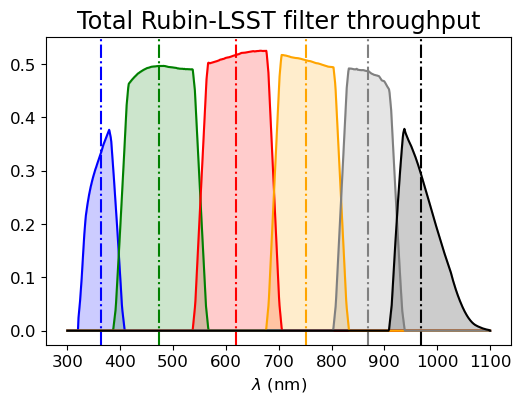

In [8]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

In [9]:
saveDir = "./lc_output_auxtelfall2023_spectro"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [10]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 50  # 100

In [11]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
# collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648"
collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

collectionStr = collection.replace("/", "_")
instrument = "LATISS"
skymapName = "latiss_v1"

tract = 3864

calibFluxStr = "apFlux_35_0_instFlux"


## Selected Visits and Selected Nights

In [12]:
file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
file_selected_nights = "AuxtelSpectroData/AtmParamPerNightObsDict_fall2023.pkl"

In [13]:
df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
my_selectedvisits = list(df_myselectedvisits.index)

In [14]:
#move the visitid as a column not to loose it during the merge 
df_myselectedvisits.reset_index(inplace=True) 

In [15]:
df_myselectedvisits

,visitId,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID
0,2023112100506,20231121,SDSSg_65mm~empty,g,28.037330,60270.293207,2023-11-22 07:01:58.064996,60270.293033,2023-11-22 07:01:58.064996,1.087878,3864,237
1,2023112100507,20231121,SDSSr_65mm~empty,r,27.826233,60270.293745,2023-11-22 07:02:44.576007,60270.293571,2023-11-22 07:02:44.576007,1.086620,3864,237
2,2023112100508,20231121,SDSSz_65mm~empty,z,27.281532,60270.294284,2023-11-22 07:03:31.156006,60270.294111,2023-11-22 07:03:31.156006,1.085371,3864,237
3,2023112100509,20231121,empty~SDSSy_65mm,y,26.175438,60270.294842,2023-11-22 07:04:19.313506,60270.294668,2023-11-22 07:04:19.313506,1.084094,3864,237
4,2023112100510,20231121,SDSSg_65mm~empty,g,28.049168,60270.295844,2023-11-22 07:05:45.944508,60270.295671,2023-11-22 07:05:45.944508,1.081935,3864,236
...,...,...,...,...,...,...,...,...,...,...,...,...
871,2023122200530,20231222,empty~SDSSy_65mm,y,26.290860,60301.274438,2023-12-23 06:34:56.432498,60301.274264,2023-12-23 06:34:56.432498,1.006569,3864,236
872,2023122200531,20231222,SDSSg_65mm~empty,g,28.088020,60301.275506,2023-12-23 06:36:28.743997,60301.275333,2023-12-23 06:36:28.743997,1.006333,3864,236
873,2023122200532,20231222,SDSSr_65mm~empty,r,27.858763,60301.276044,2023-12-23 06:37:15.228995,60301.275871,2023-12-23 06:37:15.228995,1.006219,3864,236
874,2023122200533,20231222,SDSSz_65mm~empty,z,27.357218,60301.276586,2023-12-23 06:38:02.021494,60301.276412,2023-12-23 06:38:02.021494,1.006114,3864,236


In [16]:
# Check the night selected
df_myselectedvisits['nightObs'].unique()

array([20231121, 20231127, 20231128, 20231129, 20231130, 20231204,
       20231205, 20231206, 20231211, 20231214, 20231215, 20231220,
       20231221, 20231222])

### Make the dataframe holding the atmospheric parameters

In [17]:
df_selnight = pd.DataFrame(columns=('nightObs', 'PWV', 'VAOD','Grey',"Ozone"))
with open(file_selected_nights, 'rb') as fp:
    selectedNightsDict  = pickle.load(fp)
idx=0
for key,value in selectedNightsDict.items():
    pwv = value['median']['median_param_atm']['md_PWV']
    vaod = value['median']['median_param_atm']['md_VAOD']
    grey = value['median']['median_param_atm']['md_grey']
    ozone = value['median']['median_param_atm']['md_ozone']
    df_selnight.loc[idx] = [int(key),pwv,vaod,grey,ozone]
    idx+=1

In [18]:
# Convert the nightObs as an integer
df_selnight = df_selnight.astype({'nightObs':'int'})

In [19]:
df_night_to_atm = df_selnight.copy().set_index('nightObs')

In [20]:
df_night_to_atm

,PWV,VAOD,Grey,Ozone
nightObs,,,,
20230927,1.360643,0.006606,0.962204,322.459010
20230928,2.172185,0.000000,0.957690,309.241099
20231010,2.323852,0.006589,0.963656,328.488524
20231107,2.101962,0.013239,0.972018,304.659232
20231113,2.547404,0.009443,0.962289,339.184216
20231114,2.880052,0.009948,0.966162,322.515609
20231115,2.577242,0.002186,0.948540,317.834236
20231116,2.297691,0.006841,0.949698,348.357957
20231120,2.599672,0.017588,0.984415,315.151618


In [21]:
df_night_to_atm.loc[20231127]

PWV        3.551770
VAOD       0.004201
Grey       0.967583
Ozone    305.884093
Name: 20231127, dtype: float64

In [22]:
df_selnight['nightObs'].unique()

array([20230927, 20230928, 20231010, 20231107, 20231113, 20231114,
       20231115, 20231116, 20231120, 20231127, 20231128, 20231129,
       20231130, 20231204, 20231205, 20231206, 20231207])

## Merge the two datasets

- kepp the intersection

In [23]:
df_merge = df_myselectedvisits.merge(df_selnight, left_on='nightObs',right_on='nightObs',how="inner")

In [24]:
df_merge['nightObs'].unique()

array([20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206])

In [25]:
df_myselectedvisits = df_merge.copy()

In [26]:
df_myselectedvisits

,visitId,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID,PWV,VAOD,Grey,Ozone
0,2023112700289,20231127,SDSSg_65mm~empty,g,28.049986,60276.274623,2023-11-28 06:35:12.465999,60276.274450,2023-11-28 06:35:12.465999,1.093019,3864,237,3.551770,0.004201,0.967583,305.884093
1,2023112700290,20231127,SDSSr_65mm~empty,r,27.843603,60276.275165,2023-11-28 06:35:59.225506,60276.274991,2023-11-28 06:35:59.225506,1.091708,3864,237,3.551770,0.004201,0.967583,305.884093
2,2023112700291,20231127,SDSSz_65mm~empty,z,27.314777,60276.275706,2023-11-28 06:36:45.996996,60276.275532,2023-11-28 06:36:45.996996,1.090408,3864,237,3.551770,0.004201,0.967583,305.884093
3,2023112700292,20231127,empty~SDSSy_65mm,y,26.169914,60276.276261,2023-11-28 06:37:33.978497,60276.276088,2023-11-28 06:37:33.978497,1.089088,3864,237,3.551770,0.004201,0.967583,305.884093
4,2023112700293,20231127,SDSSg_65mm~empty,g,28.077412,60276.277268,2023-11-28 06:39:00.978991,60276.277095,2023-11-28 06:39:00.978991,1.086840,3864,237,3.551770,0.004201,0.967583,305.884093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,2023120600314,20231206,empty~SDSSy_65mm,y,26.273216,60285.309672,2023-12-07 07:25:40.656999,60285.309498,2023-12-07 07:25:40.656999,1.009665,3864,236,1.745412,0.007880,0.949152,313.621492
427,2023120600315,20231206,SDSSg_65mm~empty,g,28.086746,60285.310672,2023-12-07 07:27:07.101494,60285.310499,2023-12-07 07:27:07.101494,1.009217,3864,236,1.745412,0.007880,0.949152,313.621492
428,2023120600316,20231206,SDSSr_65mm~empty,r,27.864086,60285.311213,2023-12-07 07:27:53.827494,60285.311040,2023-12-07 07:27:53.827494,1.008973,3864,236,1.745412,0.007880,0.949152,313.621492
429,2023120600317,20231206,SDSSz_65mm~empty,z,27.352793,60285.311755,2023-12-07 07:28:40.619498,60285.311581,2023-12-07 07:28:40.619498,1.008738,3864,236,1.745412,0.007880,0.949152,313.621492


In [27]:
my_selectedvisits = list(df_myselectedvisits.visitId)

In [28]:
df_atm = df_myselectedvisits[["visitId","PWV","VAOD","Grey","Ozone"]]

## Config

In [29]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collection, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LATISS
collection = LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871


In [30]:
# Try to get the Schema
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collection, where= "instrument='LATISS'")
for i, ref in enumerate(datasetRefs):
    print(i,ref)
    butler_data = butler.get(ref)
    break

if not isinstance(butler_data, pd.core.frame.DataFrame):
    print(butler_data.getSchema())

0 isolated_star_sources@{instrument: 'LATISS', skymap: 'latiss_v1', tract: 383} [sc=DataFrame] (run=LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871/20240206T160257Z id=784d3e58-a02e-4e74-9d48-76b15ff6921c)


## isolated_star_sources

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [31]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [32]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,713,178244558356742858,2023111500493,0,122.502819,-36.181372,empty~SDSSi_65mm,i,18175.596494,576.145944,3089.041514,3522.968126,18884.539910,812.086676,False,-0.046051,False,713,0
1,755,178244561577968372,2023111500496,0,122.502816,-36.181375,empty~SDSSi_65mm,i,17565.087785,575.726251,2534.640599,3530.208921,17731.305191,812.327495,False,0.076945,False,755,0
2,670,178244564799193759,2023111500499,0,122.502820,-36.181372,empty~SDSSi_65mm,i,18116.303929,589.631325,1981.029109,3539.453433,19207.199949,833.032409,False,0.060362,False,670,0
3,679,178244568020419240,2023111500502,0,122.502819,-36.181372,empty~SDSSi_65mm,i,17729.923577,576.995488,1425.821552,3545.346614,18735.842581,814.675518,False,0.163642,False,679,0
4,576,178244574462870081,2023111500508,0,122.502817,-36.181375,empty~SDSSi_65mm,i,19275.159892,574.297890,315.295535,3562.070830,21449.774805,811.090466,False,0.462267,False,576,0


In [33]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

## Select the visits in the preselected list

I add here my filter to select the visits I want to focus on from file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
It include all bands

In [34]:
def SelectByVisit(row):
    if row["visit"] in my_selectedvisits:
        return True
    else:
        return False

In [35]:
isolatedStarSourcesFull["flag"] = isolatedStarSourcesFull.apply(SelectByVisit,axis=1,raw=False)

In [36]:
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["flag"]]
isolatedStarSourcesFull.drop("flag",axis=1,inplace=True)

In [37]:
isolatedStarSourcesFull

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
65,457,178666553925960138,2023112700291,0,122.502820,-36.181375,SDSSz_65mm~empty,z,12747.998105,581.753474,3382.237020,2386.535105,13625.474026,823.982022,False,0.343975,False,457,0
66,439,178666558220927416,2023112700295,0,122.502811,-36.181367,SDSSz_65mm~empty,z,11429.435693,584.693261,2822.350901,2395.927091,10438.395404,828.670834,False,-0.285304,False,439,0
67,444,178666562515894717,2023112700299,0,122.502809,-36.181370,SDSSz_65mm~empty,z,13437.688221,598.552525,2260.433610,2402.958995,14843.517451,848.842429,False,0.230724,False,444,0
68,465,178666566810862034,2023112700303,0,122.502814,-36.181377,SDSSz_65mm~empty,z,12200.829655,608.758263,1697.099221,2408.426848,12728.064110,862.975811,False,0.265856,False,465,0
69,419,178666571105829284,2023112700307,0,122.502818,-36.181374,SDSSz_65mm~empty,z,10161.510211,595.458916,1135.841754,2416.271198,9151.938139,844.237599,False,-0.167469,False,419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152510,353,178666567884603746,2023112700304,0,122.576029,-36.164206,empty~SDSSy_65mm,y,7185.374436,533.317917,3920.129974,3026.403433,6955.290241,757.876120,False,0.034168,False,353,1339
152511,352,178702004586021217,2023112800539,0,122.576085,-36.164206,empty~SDSSy_65mm,y,7148.755773,574.771613,2837.448268,3693.434127,6602.269557,816.525462,False,-0.110343,False,352,1339
152512,406,178737183589400983,2023112900534,0,122.576099,-36.164219,empty~SDSSy_65mm,y,7905.773580,536.178851,3606.528284,3613.604361,7810.166903,762.255784,False,-0.154883,False,406,1339
152513,115,178772378698907764,2023113000544,0,122.581152,-36.233899,empty~SDSSy_65mm,y,416775.825060,825.279582,3894.570463,1092.870408,437487.553789,1011.282391,False,1.237371,False,115,1340


## Add atmospheric quantities to the isolatedStarSourcesFull

In [38]:
isolatedStarSourcesFull = isolatedStarSourcesFull.merge(df_atm, left_on='visit',right_on='visitId',how="inner")
isolatedStarSourcesFull["nightObs"] = isolatedStarSourcesFull.apply(lambda x: x['visit']//100_000, axis=1)
isolatedStarSourcesFull

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
0,457,178666553925960138,2023112700291,0,122.502820,-36.181375,SDSSz_65mm~empty,z,12747.998105,581.753474,3382.237020,2386.535105,13625.474026,823.982022,False,0.343975,False,457,0,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
1,514,178666553925960195,2023112700291,0,122.497986,-36.173216,SDSSz_65mm~empty,z,14464.894159,585.974220,3239.489619,2695.313259,14665.370806,828.493855,False,-0.056541,False,514,2,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
2,505,178666553925960186,2023112700291,0,122.486996,-36.174438,SDSSz_65mm~empty,z,46465.109238,612.160990,2905.201660,2653.676707,45553.918232,848.659952,False,-0.200783,False,505,3,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
3,411,178666553925960092,2023112700291,0,122.520431,-36.187896,SDSSz_65mm~empty,z,15814.180282,554.156331,3913.659231,2134.246089,16044.713554,782.601740,False,0.126033,False,411,5,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
4,460,178666553925960141,2023112700291,0,122.513234,-36.180948,SDSSz_65mm~empty,z,34217.183036,565.581218,3698.656528,2398.479751,35049.844366,788.184754,False,0.232790,False,460,6,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43415,156,178737288816099485,2023112900632,0,122.438489,-36.222594,empty~SDSSy_65mm,y,65860.221341,679.413319,2294.932623,1400.083499,67947.566082,938.270730,False,0.238771,False,156,1041,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
43416,360,178737288816099689,2023112900632,0,122.436026,-36.172113,empty~SDSSy_65mm,y,7718.800287,573.490174,2245.197983,3299.364090,8059.304354,815.039076,False,0.010445,False,360,1044,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
43417,256,178737288816099585,2023112900632,0,122.424413,-36.197923,empty~SDSSy_65mm,y,161716.452929,705.333578,1879.864027,2333.332603,171169.378938,930.194281,False,1.364252,False,256,1071,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129
43418,145,178737288816099474,2023112900632,0,122.381425,-36.226526,empty~SDSSy_65mm,y,7578.970429,663.062178,561.317379,1274.236020,7412.962573,943.857395,False,-0.059202,False,145,1092,2023112900632,3.137323,0.007454,0.965610,294.848216,20231129


In [39]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
0,457,178666553925960138,2023112700291,0,122.50282,-36.181375,SDSSz_65mm~empty,z,12747.998105,581.753474,3382.23702,2386.535105,13625.474026,823.982022,False,0.343975,False,457,0,2023112700291,3.55177,0.004201,0.967583,305.884093,20231127


In [40]:
print("calibFluxStr = {},minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,minSnCalibFlux = 50, minNumMatches = 3


In [41]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [42]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

# Statistic on objects

In [43]:
source_perobj_perband_pervisit = isolatedStarSourcesFull.groupby(by=["obj_index","band","visit"]).count()["ra"]

In [44]:
source_perobj_perband_pervisit

obj_index  band  visit        
0          g     2023112700289    1
                 2023112700393    1
                 2023112800499    1
                 2023112800524    1
                 2023112800548    1
                                 ..
1339       y     2023112700304    1
                 2023112800539    1
                 2023112900534    1
1340       y     2023113000544    1
1346       y     2023120400546    1
Name: ra, Length: 43420, dtype: int64

## All objects

In [45]:
list_of_object_id = sorted(isolatedStarSourcesFull["obj_index"].unique())
Nobj = len(list_of_object_id)

## Select one object

In [46]:
cut_sel_object = isolatedStarSourcesFull.obj_index == 0

In [47]:
isolatedStarSources_selected = isolatedStarSourcesFull[cut_sel_object]

In [48]:
isolatedStarSources_selected.groupby(by="band").count()["index"] 

band
g    48
r    82
y     2
z    83
Name: index, dtype: int64

### Number of visit in y

In [49]:
NYMIN = 50. # minimum number of visit in Y band
NBANDMIN = 4 # nimimum number of bands

In [50]:
obj_idx_selected = []

for idx in range(Nobj):
    cut_sel_object = isolatedStarSourcesFull.obj_index == idx
    isolatedStarSources_selected = isolatedStarSourcesFull[cut_sel_object]
    
    ser= isolatedStarSources_selected.groupby(by="band").count()["index"]
    nband = len(ser)
    if "y" in ser.index and nband>= NBANDMIN:
        NY = ser["y"]
        if NY>NYMIN:
            #print(f"------------------------ {idx} ------------------------------")
            #print(ser,len(ser))
            obj_idx_selected.append(idx)
    
    

In [51]:
print(obj_idx_selected)

[3, 6, 9, 10, 12, 15, 18, 22, 24, 28, 29, 33, 34, 35, 36, 38, 39, 43, 49, 50, 62, 63, 79, 81, 96, 97, 102, 104, 108, 111, 137, 154, 280, 294, 342, 356, 358, 407, 425, 670, 766]


In [52]:
idx_obj_sel = 3
cut_sel_object = isolatedStarSourcesFull.obj_index == idx_obj_sel 
isolatedStarSources_sel = isolatedStarSourcesFull[cut_sel_object] 

In [53]:
isolatedStarSources_sel

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,visitId,PWV,VAOD,Grey,Ozone,nightObs
2,505,178666553925960186,2023112700291,0,122.486996,-36.174438,SDSSz_65mm~empty,z,46465.109238,612.160990,2905.201660,2653.676707,45553.918232,848.659952,False,-0.200783,False,505,3,2023112700291,3.551770,0.004201,0.967583,305.884093,20231127
143,486,178666558220927463,2023112700295,0,122.486998,-36.174441,SDSSz_65mm~empty,z,47865.536658,624.632634,2345.578516,2662.571969,48029.537359,866.451184,False,-0.054229,False,486,3,2023112700295,3.551770,0.004201,0.967583,305.884093,20231127
285,496,178666562515894769,2023112700299,0,122.486999,-36.174440,SDSSz_65mm~empty,z,47326.503774,638.653092,1783.713514,2669.612957,46742.027745,886.260335,False,-0.202884,False,496,3,2023112700299,3.551770,0.004201,0.967583,305.884093,20231127
421,519,178666566810862088,2023112700303,0,122.486998,-36.174437,SDSSz_65mm~empty,z,46564.162456,624.100423,1220.151923,2675.423434,46214.960636,865.191971,False,-0.152187,False,519,3,2023112700303,3.551770,0.004201,0.967583,305.884093,20231127
670,505,178666575400796666,2023112700311,0,122.487007,-36.174438,SDSSz_65mm~empty,z,48058.350799,624.543559,98.001523,2690.076105,48462.041228,864.542355,False,-0.030944,False,505,3,2023112700311,3.551770,0.004201,0.967583,305.884093,20231127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38234,527,178983170325086736,2023120600251,0,122.487002,-36.174439,empty~SDSSy_65mm,y,21210.076107,597.621361,951.293807,3487.231103,21956.841100,841.728726,False,0.066371,False,527,3,2023120600251,1.745412,0.007880,0.949152,313.621492,20231206
38334,311,178983183209988408,2023120600263,0,122.487005,-36.174436,empty~SDSSy_65mm,y,20125.625656,581.040604,3725.486912,1961.345031,18912.903246,812.624607,False,-0.229694,False,311,3,2023120600263,1.745412,0.007880,0.949152,313.621492,20231206
38418,235,178983220790952172,2023120600298,0,122.487001,-36.174437,empty~SDSSy_65mm,y,19273.621509,668.792298,2577.509265,1977.029611,18757.092628,925.954740,False,-0.295400,False,235,3,2023120600298,1.745412,0.007880,0.949152,313.621492,20231206
38491,286,178983225085919519,2023120600302,0,122.487001,-36.174442,empty~SDSSy_65mm,y,21347.517965,631.160775,2028.697583,1987.605436,21123.374613,885.355261,False,-0.144941,False,286,3,2023120600302,1.745412,0.007880,0.949152,313.621492,20231206


In [54]:
isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

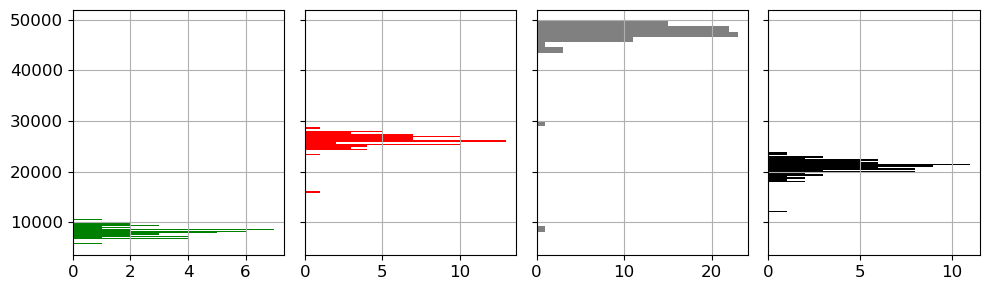

In [55]:
fig,axes = plt.subplots(1,4,figsize=(10,3),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    if idx==0:
        isolatedStarSources_sel_g["apFlux_35_0_instFlux"].hist(bins=40,facecolor="g",ax=ax, orientation="horizontal")
    elif idx==1:
        isolatedStarSources_sel_r["apFlux_35_0_instFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
    elif idx==2:
        isolatedStarSources_sel_z["apFlux_35_0_instFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
    elif idx==3:
        isolatedStarSources_sel_y["apFlux_35_0_instFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
plt.tight_layout(h_pad=0)        
#plt.tight_layout()

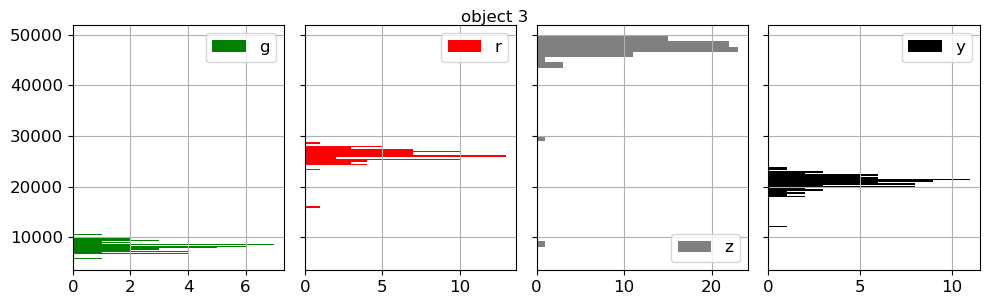

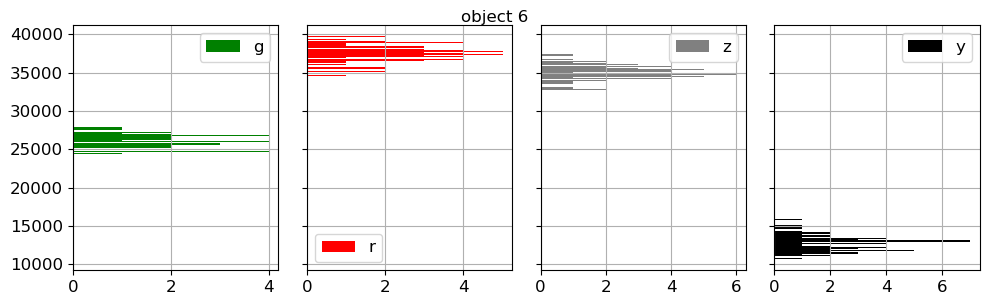

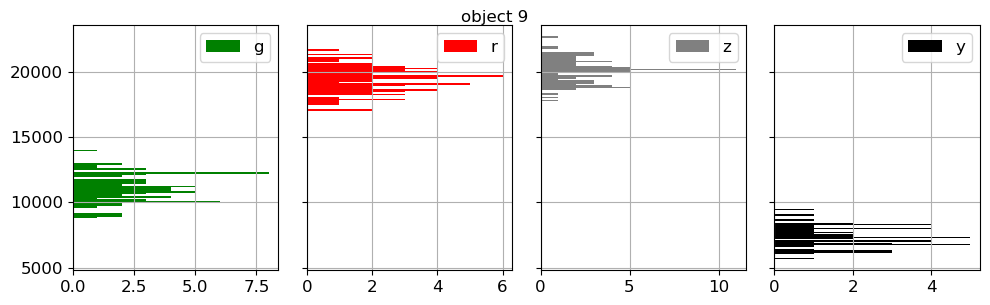

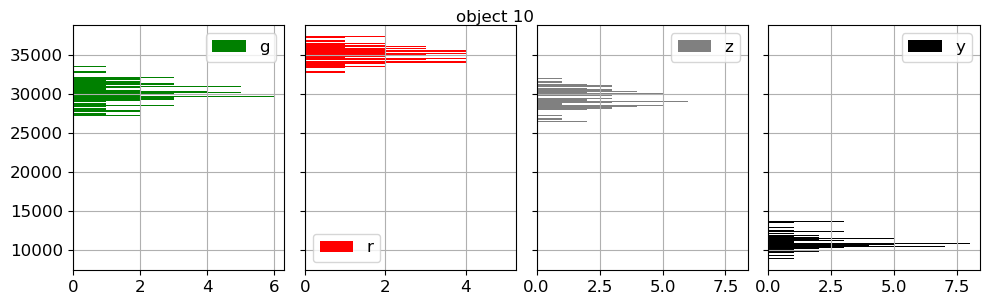

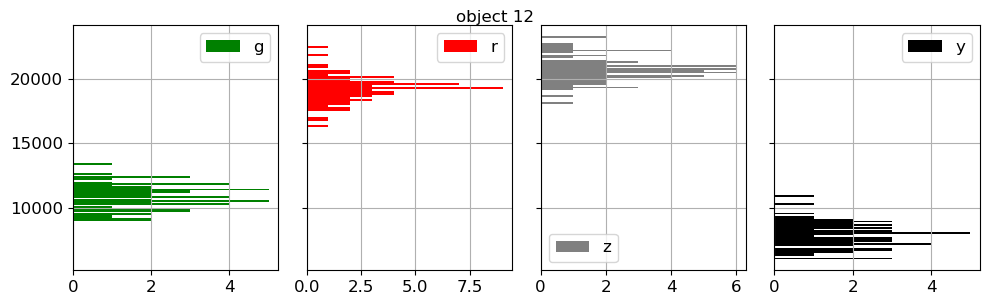

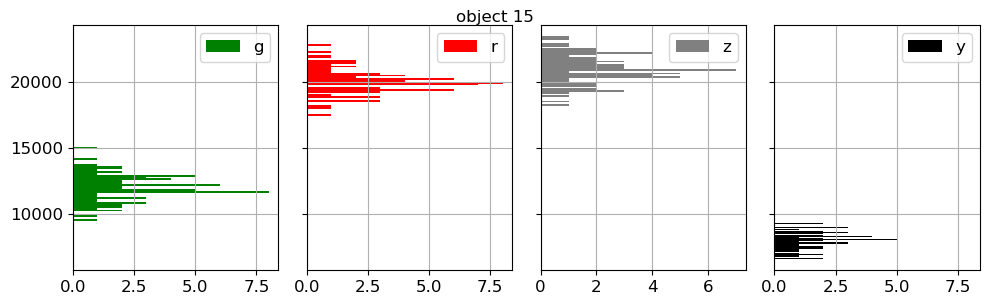

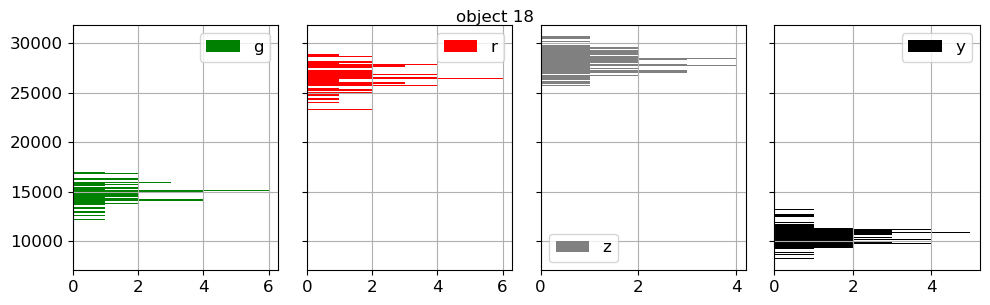

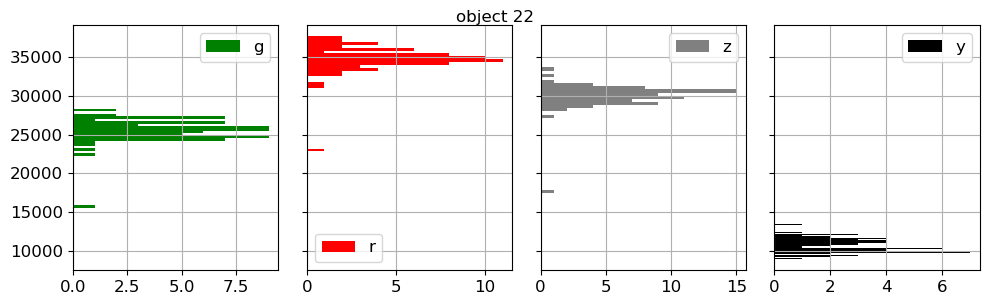

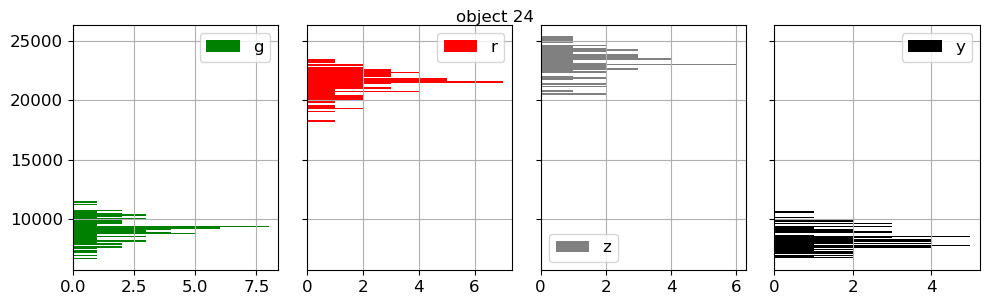

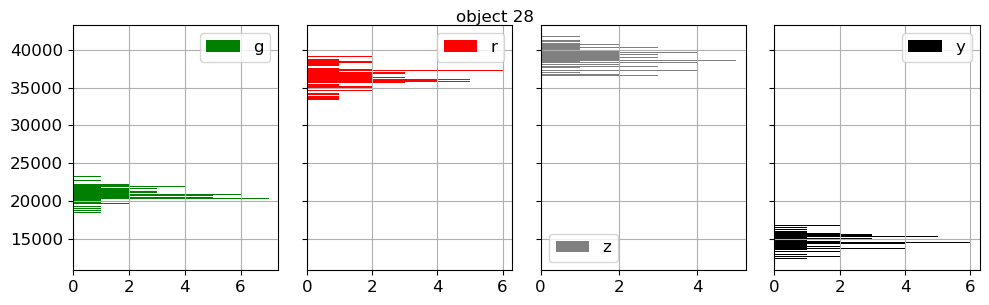

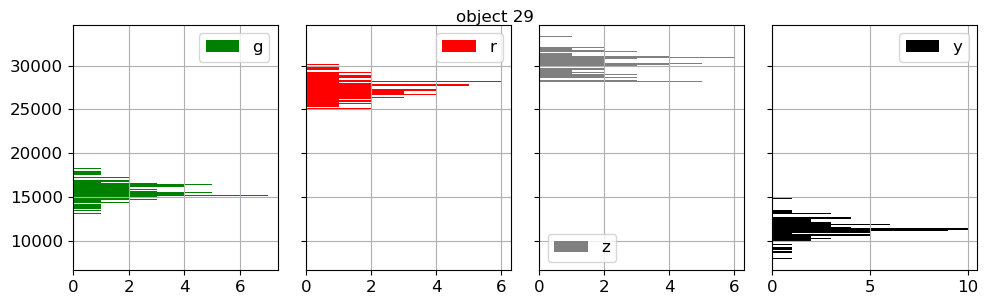

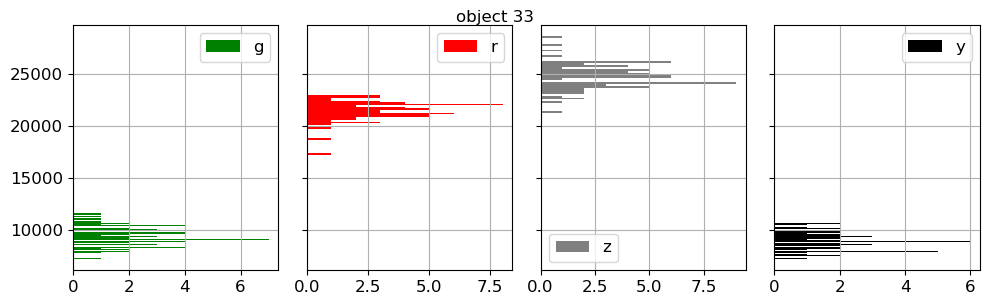

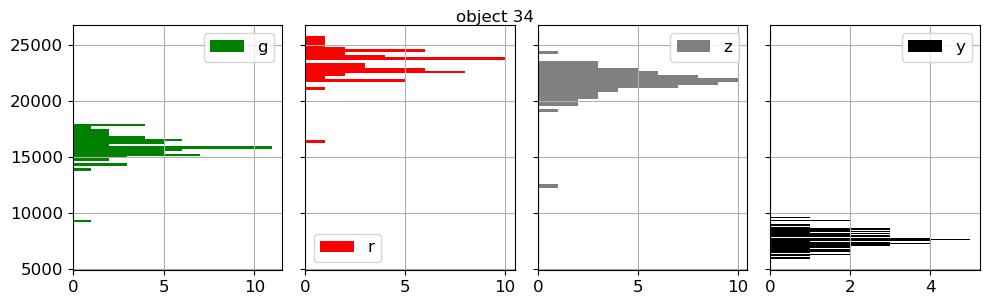

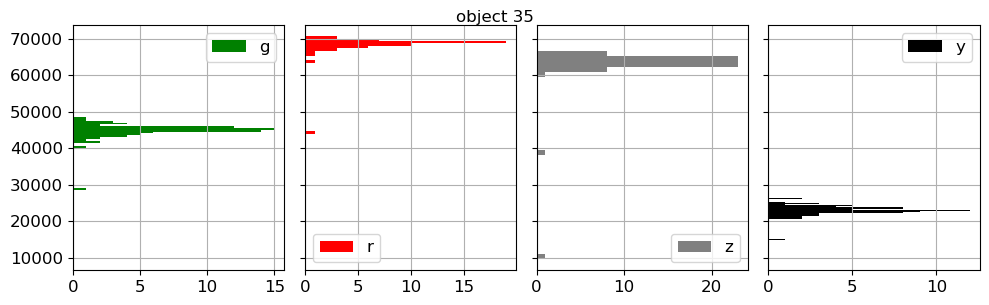

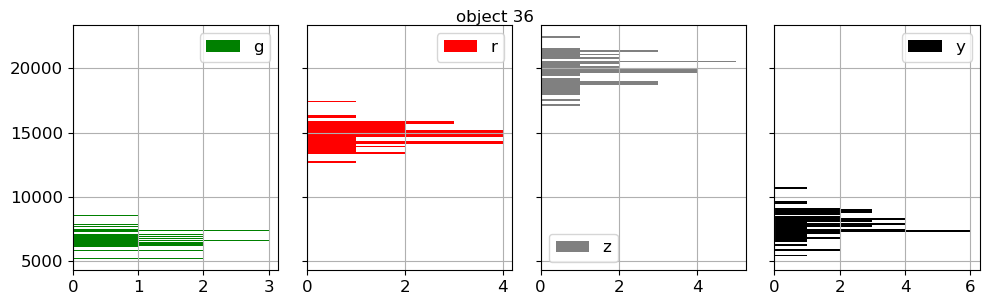

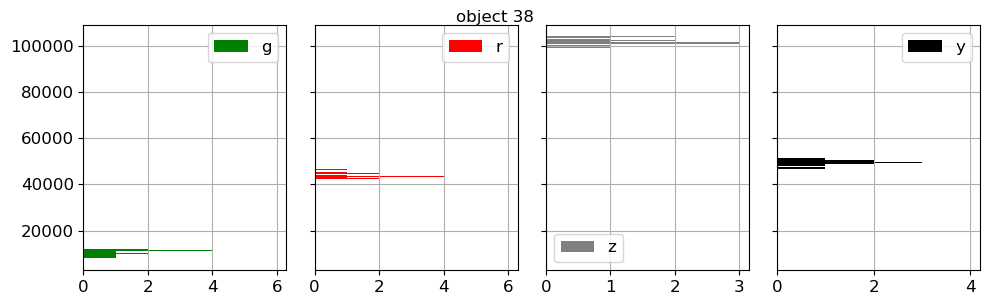

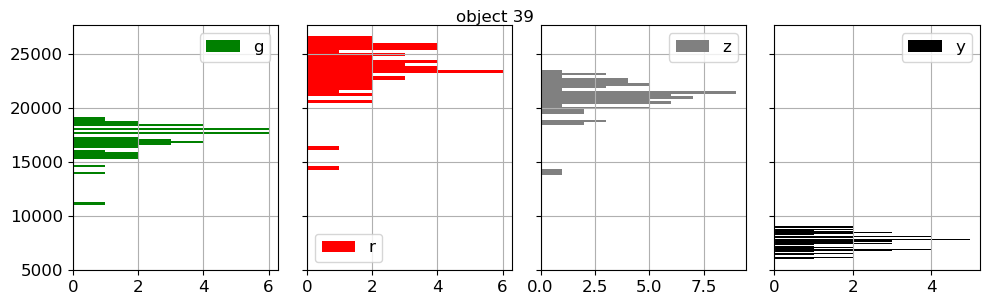

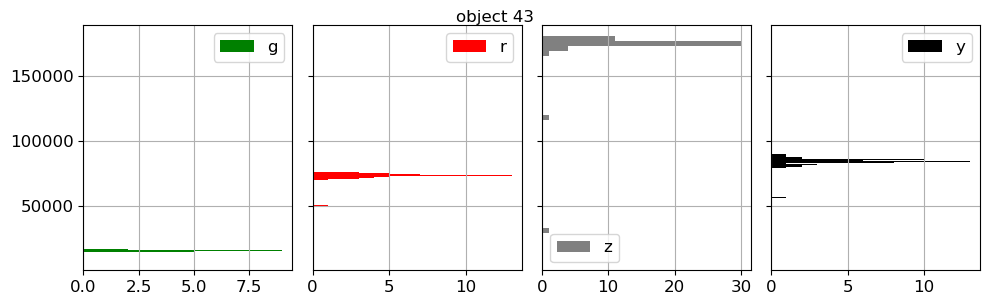

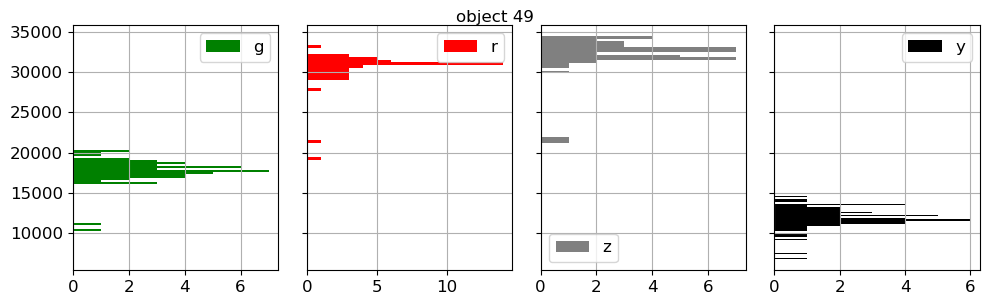

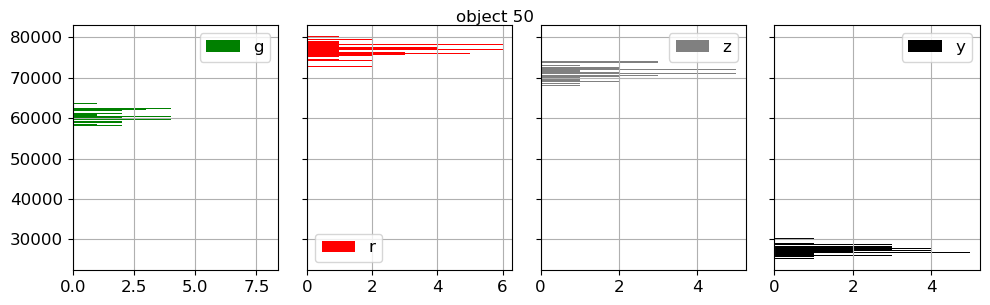

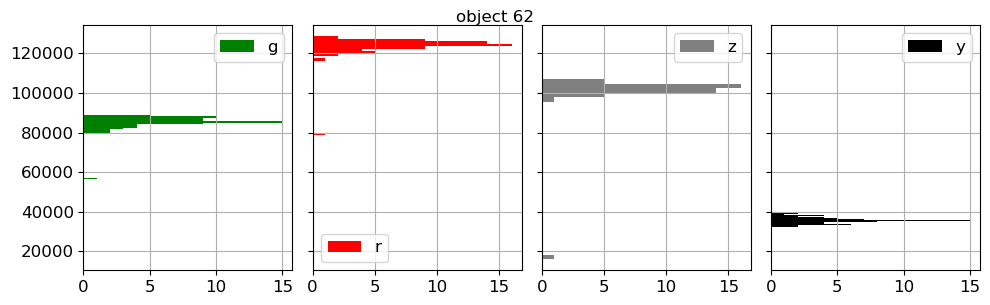

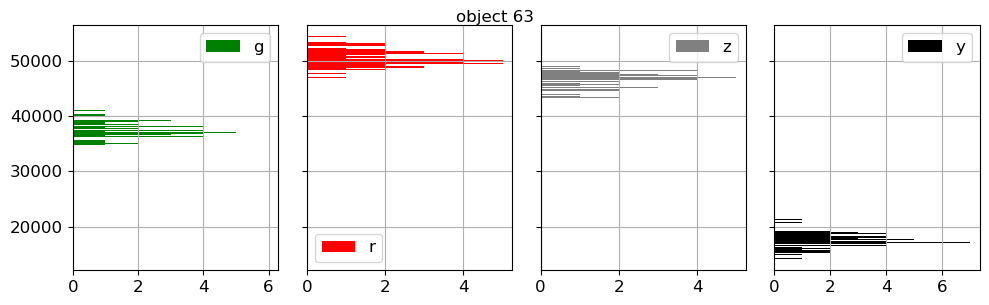

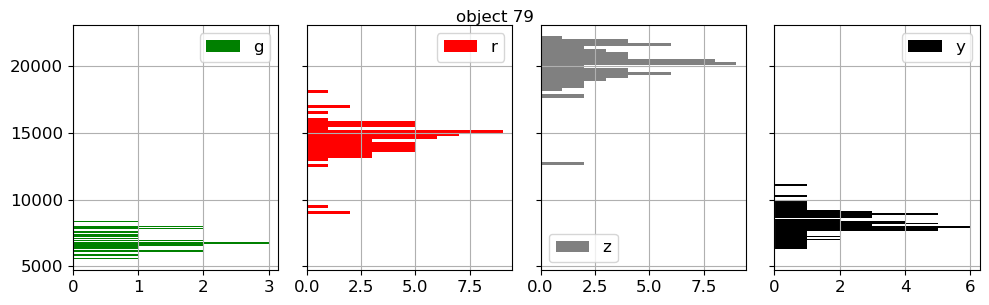

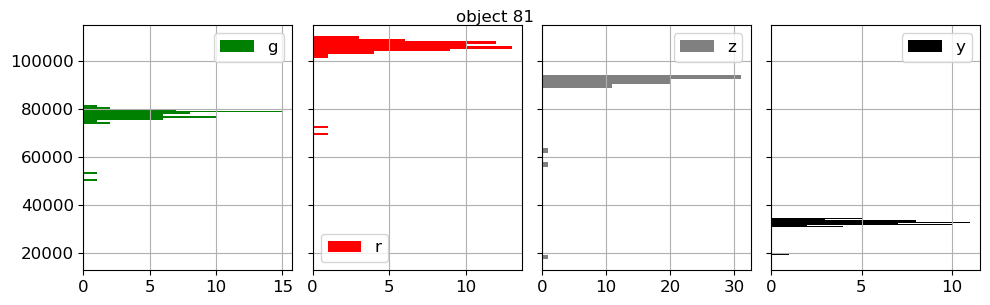

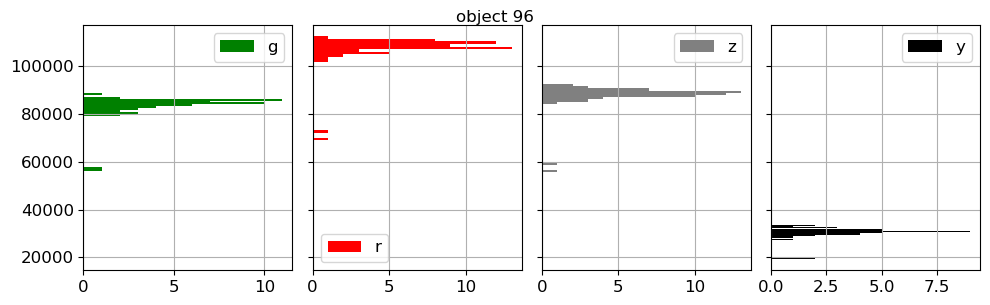

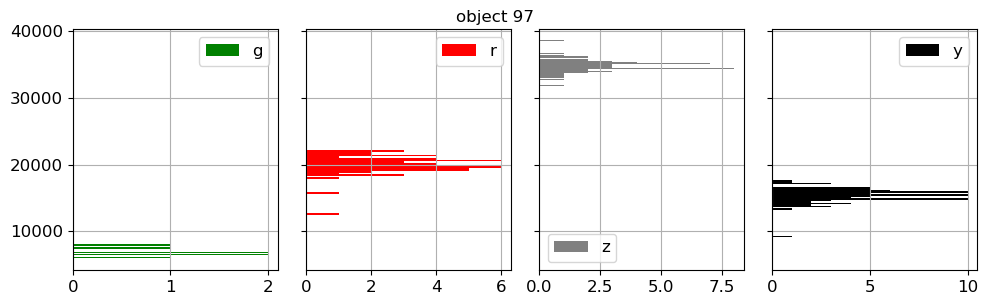

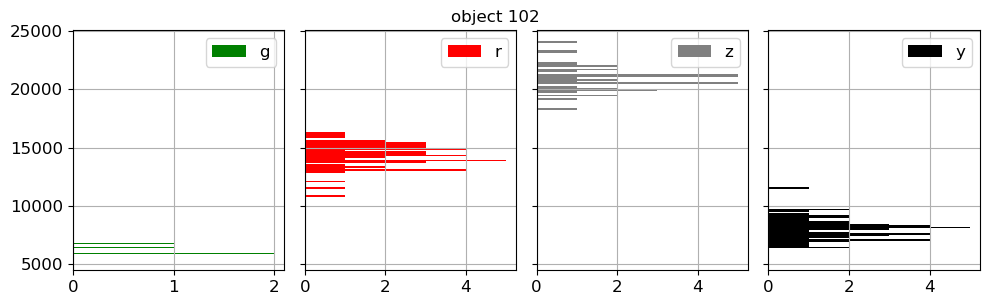

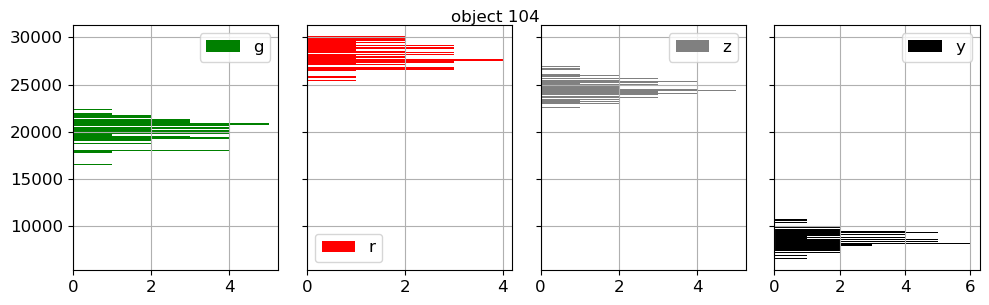

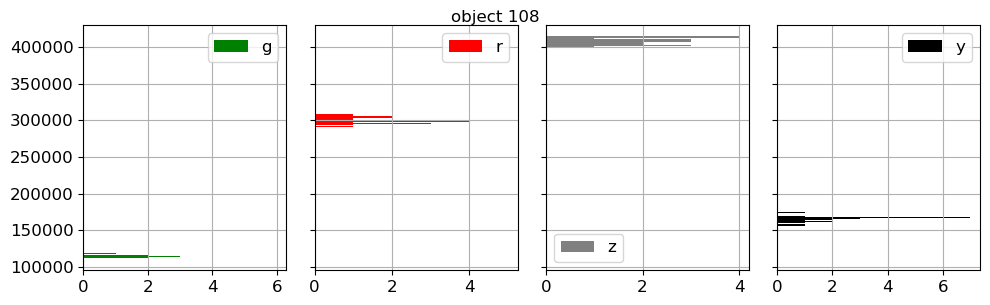

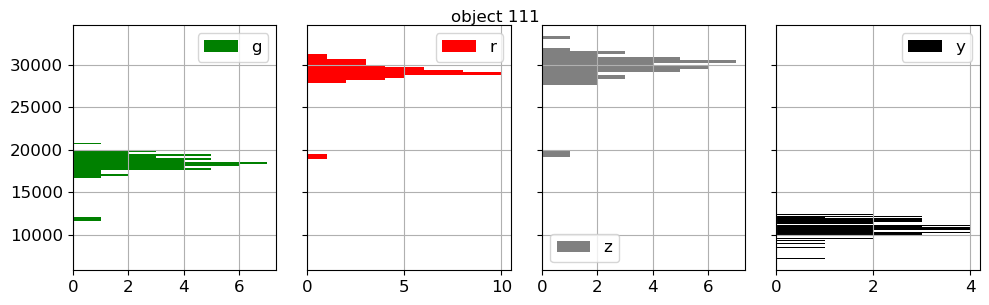

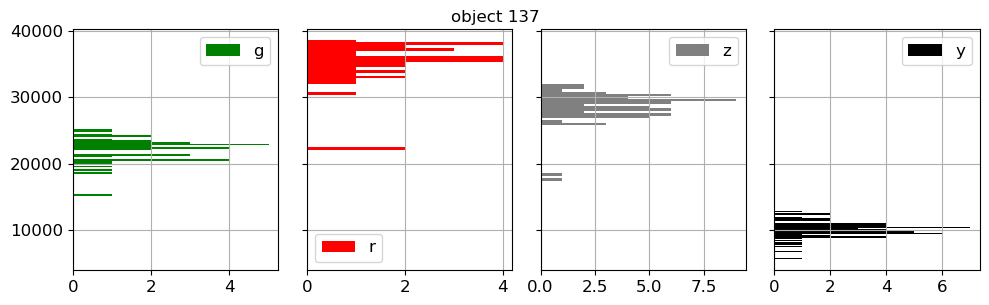

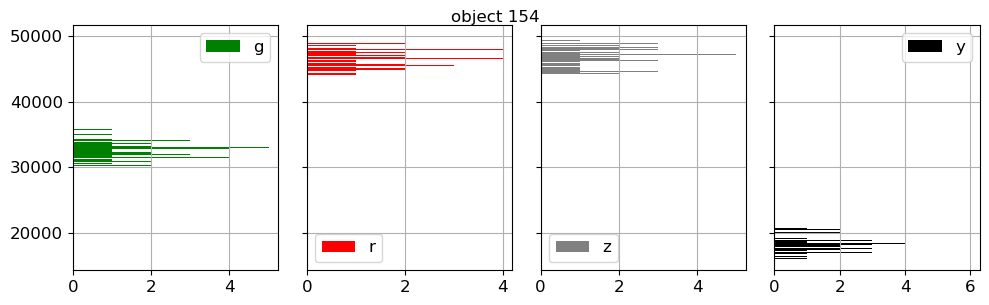

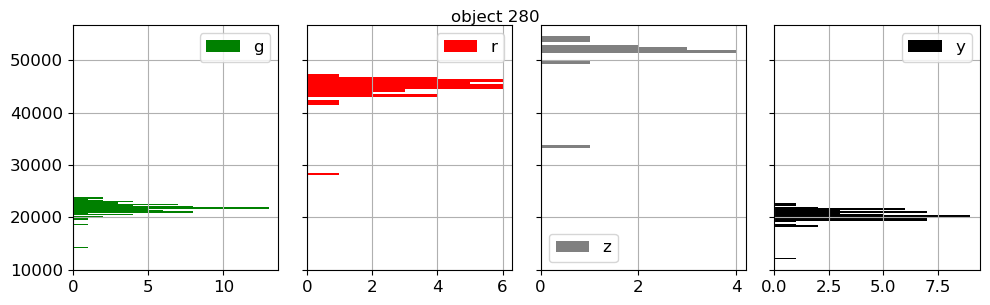

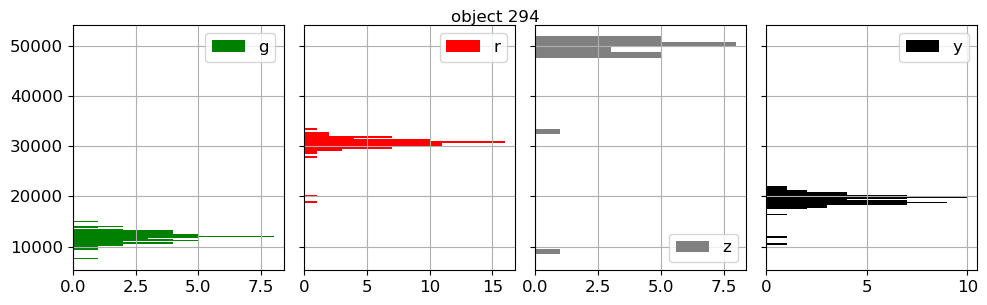

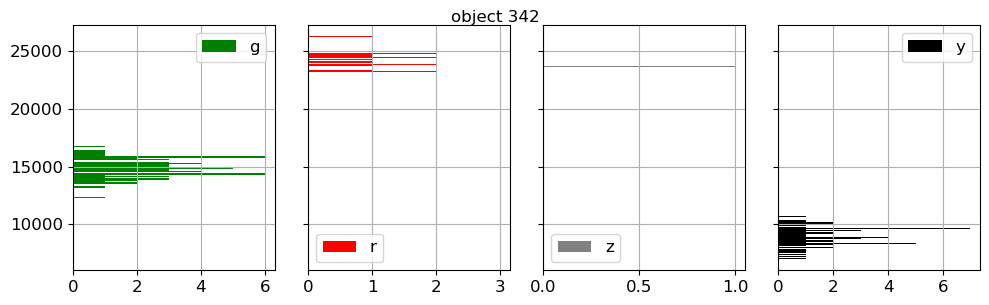

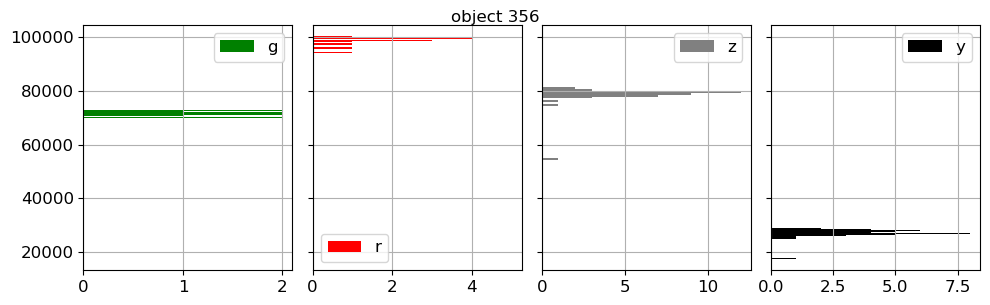

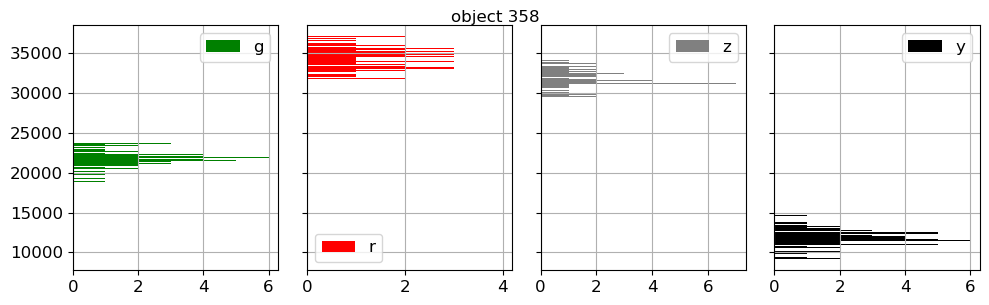

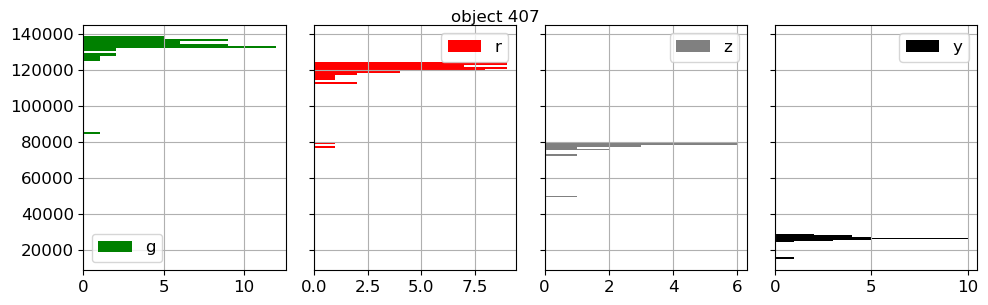

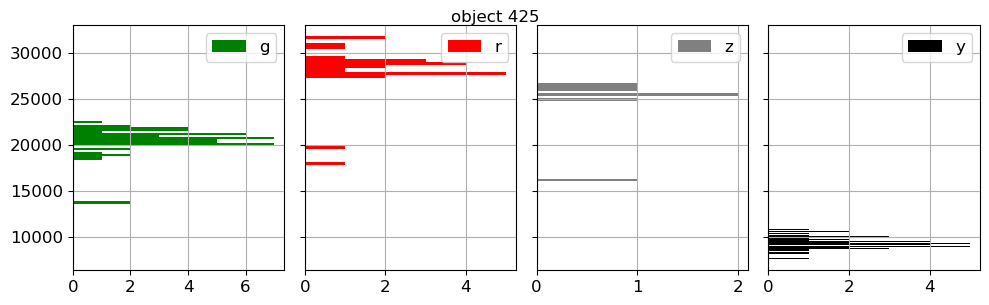

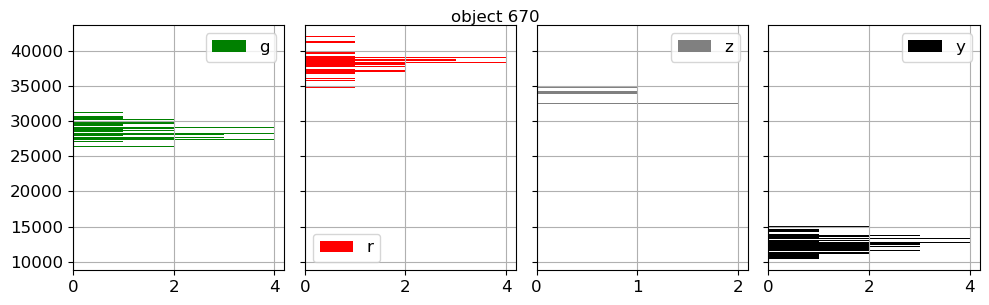

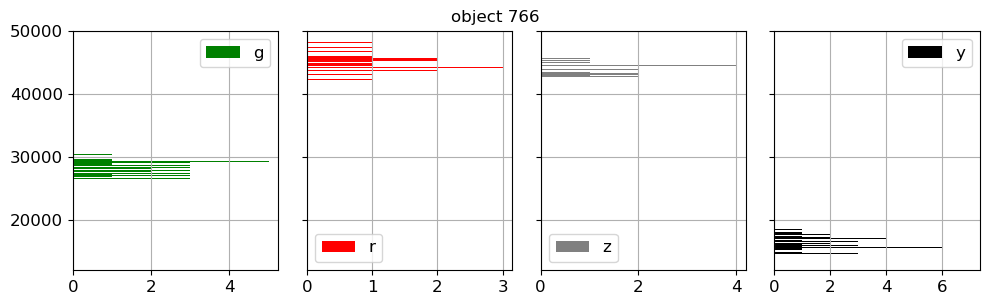

In [58]:
for idx_obj_sel in obj_idx_selected:
    cut_sel_object = isolatedStarSourcesFull.obj_index == idx_obj_sel 
    isolatedStarSources_sel = isolatedStarSourcesFull[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    fig,axes = plt.subplots(1,4,figsize=(10,3),sharey=True)
    axs= axes.flatten()
    for idx,ax in enumerate(axs):
        if idx==0:
            isolatedStarSources_sel_g["apFlux_35_0_instFlux"].hist(bins=40,facecolor="g",ax=ax, orientation="horizontal")
            ax.legend("g")
        elif idx==1:
            isolatedStarSources_sel_r["apFlux_35_0_instFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
            ax.legend("r")
        elif idx==2:
            isolatedStarSources_sel_z["apFlux_35_0_instFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
            ax.legend("z")
        elif idx==3:
            isolatedStarSources_sel_y["apFlux_35_0_instFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
            ax.legend("y")
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    filename = f"sed_color_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    plt.savefig(filename)
    plt.show()
    